Two new contributions:

1.  Using existing experimental data from literature to model specifications 
2.  Scaling up synthetic biology designs

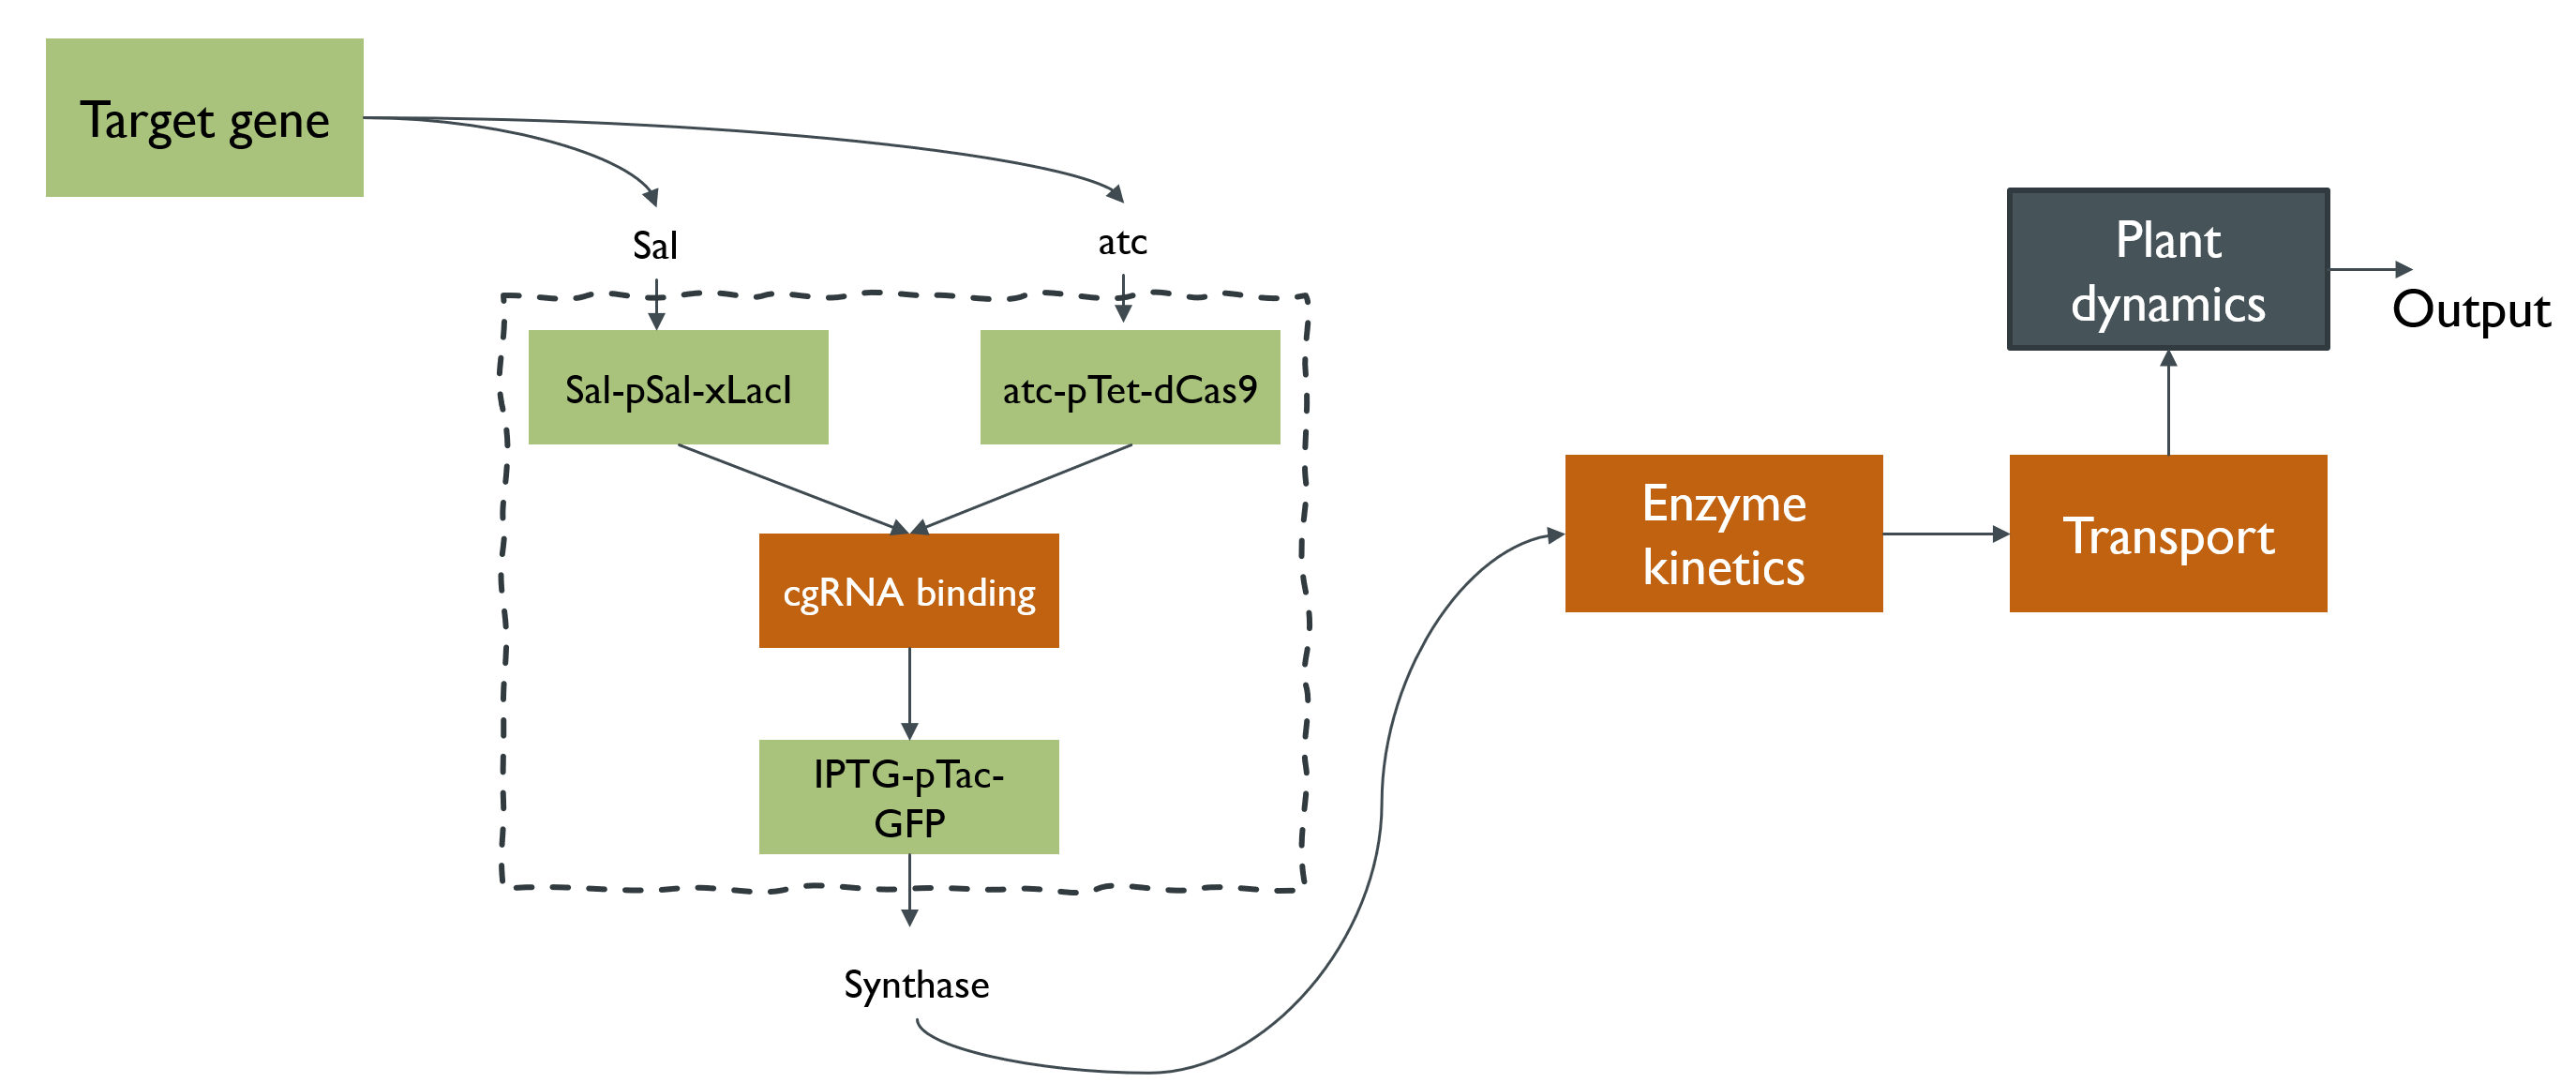

For the RFP control circuit:

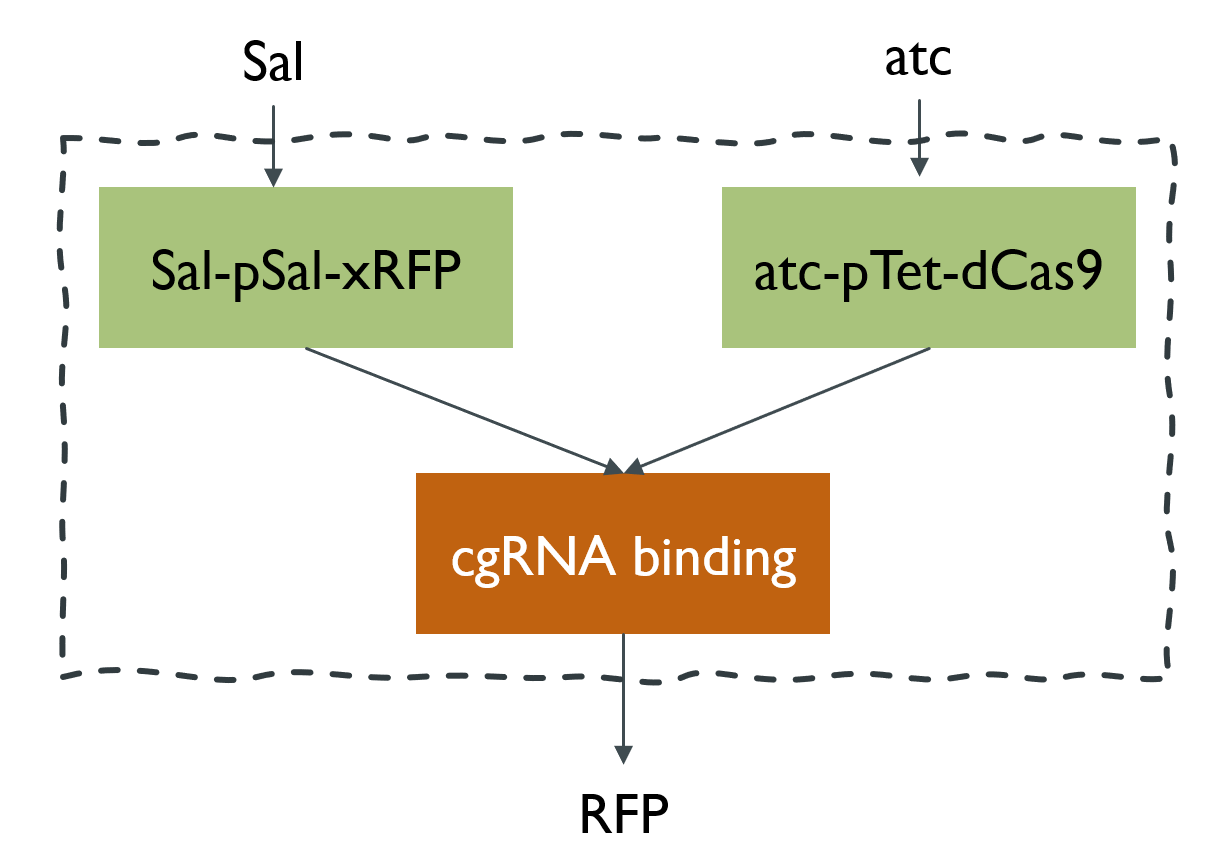

Subsystem 1: atc -> pSal -> xRFP gRNA

Subsystem 2: pConst -> RFP |- xRFP & dCas9

Subsystem 3: atc -| TetR -| pTet -> dCas9

Characterized parts availale: 
1. atc -| TetR -| pTet
2. pConst -> RFP
3. Sal -> pSal

In [50]:
import pandas as pd
from io import StringIO
# Read the data from a string
data = '''
Inducer,Plasmid,Regulator,Promoter,ymax (RPU),ymin (RPUx10-3),K (µM),n,Dynamic range,start,ymax Linear
DAPG,pAJM.847,PhlFAM,PPhlF,2.50,2.5,1.700,2.1,1000,0.03,2 
Cuma,pAJM.657,CymRAM,PCymRC,3.70,4.3,8.900,2.4,870,0.3,2
OC6,pAJM.474,LuxR,PLuxB,1.30,2.4,0.120,1.8,540,0.002,0.5
Van,pAJM.773,VanRAM,PVanCC,3.00,2.4,26.000,2.3,1200,1,1.8
IPTG,pAJM.336,LacIAM,PTac,3.30,4.8,140.000,1.8,690,2,1.5
aTc,pAJM.011,TetR,PTet*,2.40,4.9,0.013,3.8,500,0.0018,1
Ara,pAJM.677,AraCAM,PBAD,1.20,2.4,37.000,1.5,500,0.2,0.7
Cho,pAJM.683,BetIAM,PBetI,2.60,8.5,4100.00,2.7,310,300,0.9
Nar,pAJM.661,TtgRAM,PTtg,0.46,3.4,95.000,1.9,140,2,0.2
DHBA,pAJM.690,PcaUAM,P3B5B,1.60,4.5,370.000,1.8,360,9,1
Sal,pAJM.771,NahRAM,PSalTTC,2.80,4.7,43.000,1.8,600,0.9,1.3
OHC14,pAJM.1642,CinRAM,PCin,1.50,3.0,0.430,2.3,490,0.016,0.7
Acr,pAJM.884,AcuRAM,PAcu,3.10,37.0,130.000,2.5,83,10,1.7
Ery,pAJM.969,MphRAM,PMph,0.29,8.0,65.000,1.5,36,2,0.18
'''
df = pd.read_csv(StringIO(data))



In [51]:
df

,Inducer,Plasmid,Regulator,Promoter,ymax (RPU),ymin (RPUx10-3),K (µM),n,Dynamic range,start,ymax Linear
0,DAPG,pAJM.847,PhlFAM,PPhlF,2.50,2.5,1.700,2.1,1000,0.0300,2.00
1,Cuma,pAJM.657,CymRAM,PCymRC,3.70,4.3,8.900,2.4,870,0.3000,2.00
2,OC6,pAJM.474,LuxR,PLuxB,1.30,2.4,0.120,1.8,540,0.0020,0.50
3,Van,pAJM.773,VanRAM,PVanCC,3.00,2.4,26.000,2.3,1200,1.0000,1.80
4,IPTG,pAJM.336,LacIAM,PTac,3.30,4.8,140.000,1.8,690,2.0000,1.50
5,aTc,pAJM.011,TetR,PTet*,2.40,4.9,0.013,3.8,500,0.0018,1.00
6,Ara,pAJM.677,AraCAM,PBAD,1.20,2.4,37.000,1.5,500,0.2000,0.70
7,Cho,pAJM.683,BetIAM,PBetI,2.60,8.5,4100.000,2.7,310,300.0000,0.90
8,Nar,pAJM.661,TtgRAM,PTtg,0.46,3.4,95.000,1.9,140,2.0000,0.20
9,DHBA,pAJM.690,PcaUAM,P3B5B,1.60,4.5,370.000,1.8,360,9.0000,1.00


Create contracts for the sensor using this experimental data:

In [78]:
def create_sensor_contracts(input="AHL", output="FP", K=0.0, yleak=0.0, start = 0.0, ymax_lin = 0.0):
    """
    Creates the contracts for a Marionette sensing subsystem
    params:
        * input (str): The inducer input to the sensor
        * output (str): The output of the genetic construct. Inducer activates the 
                        production of this output
        * K (float): The value of the Hill activation parameter K
        * yleak (float): The minimum expression of output even in absence of inducer
        * start (float): The value of inducer at which the induction starts
        * ymax_lin (float): The maximum expression of output by the inducer
                            before saturating (the end of linear regime)
    """
    slope = (ymax_lin - yleak)/(K - start)
    intercept = yleak - slope*start
    contract_0 = {
            "_comment": "contract when sensor is OFF",
            "InputVars":[
                input
            ],
            "OutputVars":[
                output
            ],
            "assumptions":
            [
                {"coefficients":{input:1},
                "constant":start}
            ],
            "guarantees":[
                {"coefficients":{output:1},
                "constant":yleak}
            ]
        }
    contract_lin = {
            "_comment": "contract for sensor in linear regime",
            "InputVars":[
                input
            ],
            "OutputVars":[
                output
            ],
            "assumptions":
            [
                {"coefficients":{input:1},
                "constant":K},
                {"coefficients":{input:-1},
                "constant":-start}
            ],
            "guarantees":[
                {"coefficients":{output:-1, input:slope},
                "constant":intercept},
                {"coefficients":{output:1, input:-slope},
                "constant":-intercept}
            ]
        }
    contract_max = {
            "_comment": "contract for sensor in saturation",
            "InputVars":[
                input
            ],
            "OutputVars":[
                output
            ],
            "assumptions":
            [
                {"coefficients":{input:-1},
                "constant":-K}
            ],
            "guarantees":[
                {"coefficients":{output:-1},
                "constant":-ymax_lin}
            ]
        }
    return contract_0, contract_lin, contract_max

### Contracts for Sal sensor


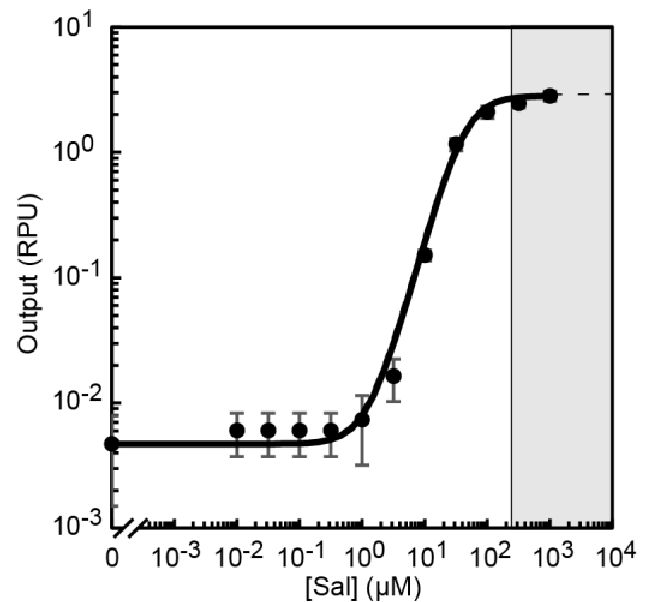

In [79]:
yleak_sal = df.loc[df["Inducer"] == "Sal"]["ymin (RPUx10-3)"].values[0]*1e-3
sal_start = df.loc[df["Inducer"] == "Sal"]["start"].values[0]
sal_K = df.loc[df["Inducer"] == "Sal"]["K (µM)"].values[0]
ymax_sal = df.loc[df["Inducer"] == "Sal"]["ymax Linear"].values[0]

sal_output = "xRFP"
contract_sal_min, contract_sal_lin, contract_sal_max = create_sensor_contracts(input="Sal", output=sal_output, 
                                                                               start=sal_start, K=sal_K,
                                                                               ymax_lin=ymax_sal, yleak=yleak_sal)

### Contracts for aTc sensor

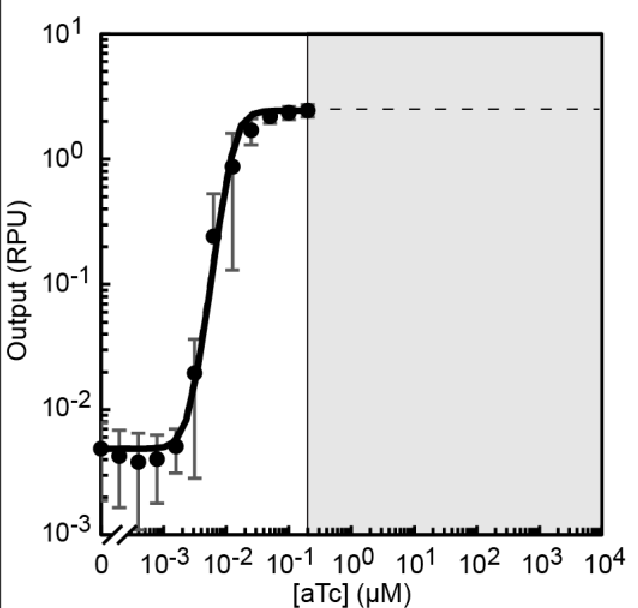

In [80]:
yleak_atc = df.loc[df["Inducer"] == "aTc"]["ymin (RPUx10-3)"].values[0]*1e-3
atc_start = df.loc[df["Inducer"] == "aTc"]["start"].values[0]
atc_K = df.loc[df["Inducer"] == "aTc"]["K (µM)"].values[0]
ymax_atc =df.loc[df["Inducer"] == "aTc"]["ymax Linear"].values[0]
atc_output = "dCas9"
contract_atc_min, contract_atc_lin, contract_atc_max = create_sensor_contracts(input="aTc", output=atc_output, 
                                                                               start=atc_start, K=atc_K,
                                                                               ymax_lin=ymax_atc, yleak=yleak_atc)

### Top-level system contract

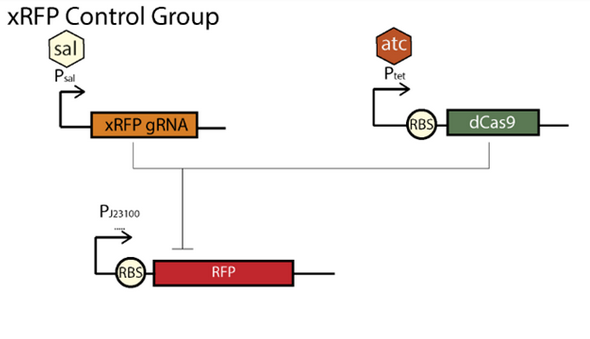

In [81]:
import numpy as np
leak_RFP = np.max([yleak_atc, yleak_sal])
max_RFP = np.max([ymax_atc, ymax_sal])
contract_top_level_on1 = {
        "_comment": "sal:OFF, atc:OFF, rfp:ON",
        "InputVars":[
            "sal", "atc"
        ],
        "OutputVars":[
            "RFP"
        ],
        "assumptions":
        [
            {"coefficients":{"sal":1},
            "constant":sal_start - sal_start*0.01},
            {"coefficients":{"atc":1},
            "constant":atc_start - atc_start*0.01}
        ],
        "guarantees":[
            {"coefficients":{"RFP":-1},
            "constant":-max_RFP},
        ]
    }
contract_top_level_on2 = {
        "_comment": "sal:ON, atc:OFF, rfp:ON",
        "InputVars":[
            "sal", "atc"
        ],
        "OutputVars":[
            "RFP"
        ],
        "assumptions":
        [
            {"coefficients":{"sal":-1},
            "constant":-(sal_start + sal_start*0.01)},
            {"coefficients":{"sal":1},
            "constant":sal_K - sal_K*0.01},
            {"coefficients":{"atc":1},
            "constant":atc_start - atc_start*0.01}
        ],
        "guarantees":[
            {"coefficients":{"RFP":-1},
            "constant":-max_RFP},
        ]
    }
contract_top_level_on3 = {
        "_comment": "sal:OFF, atc:ON, rfp:ON",
        "InputVars":[
            "sal", "atc"
        ],
        "OutputVars":[
            "RFP"
        ],
        "assumptions":
        [
            {"coefficients":{"sal":1},
            "constant":sal_start - sal_start*0.01},
            {"coefficients":{"atc":-1},
            "constant":-(atc_start + atc_start*0.01)},
            {"coefficients":{"atc":1},
            "constant":atc_K - atc_K*0.01},
        ],
        "guarantees":[
            {"coefficients":{"RFP":-1},
            "constant":-max_RFP},
        ]
    }
contract_top_level_off = {
        "_comment": "sal:ON, atc:ON, rfp:OFF",
        "InputVars":[
            "sal", "atc"
        ],
        "OutputVars":[
            "RFP"
        ],
        "assumptions":
        [
            {"coefficients":{"sal":-1},
            "constant":-(sal_start + sal_start*0.01)},
            {"coefficients":{"sal":1},
            "constant":sal_K - sal_K*0.01},
            {"coefficients":{"atc":-1},
            "constant":-(atc_start + atc_start*0.01)},
            {"coefficients":{"atc":1},
            "constant":atc_K - atc_K*0.01},
        ],
        "guarantees":[
            # {"coefficients":{"RFP":-1, "sal":2, "atc":2},
            # "constant":-10},
            {"coefficients":{"RFP":1},
            "constant":leak_RFP},   
        ]
    }

In [82]:
from gear.terms.polyhedra.loaders import read_contract, write_contract
csal_OFF, csal_ON, csal_SAT = read_contract([contract_sal_min, contract_sal_lin, contract_sal_max])
catc_OFF, catc_ON, catc_SAT = read_contract([contract_atc_min, contract_atc_lin, contract_atc_max])
ctop_00, ctop_10, ctop_01, ctop_11 = read_contract([contract_top_level_on1, contract_top_level_on2, contract_top_level_on3, contract_top_level_off])

In [83]:
print(catc_ON)

InVars: [<Var aTc>]
OutVars:[<Var dCas9>]
A: 1*aTc <= 0.013, -1*aTc <= -0.0018
G: 88.84821428571429*aTc + -1.0*dCas9 <= -0.15502678571428574, -88.84821428571429*aTc + 1.0*dCas9 <= 0.15502678571428574


In [84]:
print(csal_ON)

InVars: [<Var Sal>]
OutVars:[<Var xRFP>]
A: 1*Sal <= 43.0, -1*Sal <= -0.9
G: 0.03076722090261283*Sal + -1.0*xRFP <= -0.0229904988123516, -0.03076722090261283*Sal + 1.0*xRFP <= 0.02299049881235149


In [85]:
print(csal_ON.compose(catc_ON))

InVars: [<Var Sal>, <Var aTc>]
OutVars:[<Var xRFP>, <Var dCas9>]
A: 1*Sal <= 43.0, -1*Sal <= -0.9, 1*aTc <= 0.0129999999999999, -1*aTc <= -0.0018000000000000238
G: 0.03076722090261283*Sal + -1.0*xRFP <= -0.0229904988123516, -0.03076722090261283*Sal + 1.0*xRFP <= 0.02299049881235149, 88.84821428571429*aTc + -1.0*dCas9 <= -0.15502678571428574, -88.84821428571429*aTc + 1.0*dCas9 <= 0.15502678571428574


In [86]:
print(ctop_11)

InVars: [<Var sal>, <Var atc>]
OutVars:[<Var RFP>]
A: -1*sal <= -0.909, 1*sal <= 42.57, -1*atc <= -0.001818, 1*atc <= 0.01287
G: 1*RFP <= 0.004899999999999904


In [87]:
csal_atc = csal_ON.compose(catc_ON)
dCas_repression_lin = ctop_11.quotient(csal_atc)

In [88]:
print(dCas_repression_lin)

InVars: [<Var sal>, <Var atc>, <Var xRFP>, <Var dCas9>]
OutVars:[<Var RFP>, <Var Sal>, <Var aTc>]
A: -1*sal <= -0.909, 1*sal <= 42.57, -1*atc <= -0.0018179999999999863, 1*atc <= 0.012869999999999937
G: 1*RFP <= 0.004899999999999904, 1*Sal <= 43.0, -1*Sal <= -0.9, 1*aTc <= 0.0129999999999999, -1*aTc <= -0.0018000000000000238


Find contract for the missing subsystem for other conditions of the circuit:

In [89]:
print(csal_OFF)

InVars: [<Var Sal>]
OutVars:[<Var xRFP>]
A: 1*Sal <= 0.9
G: 1*xRFP <= 0.0046999999999999265


In [90]:
print(catc_ON)

InVars: [<Var aTc>]
OutVars:[<Var dCas9>]
A: 1*aTc <= 0.013, -1*aTc <= -0.0018
G: 88.84821428571429*aTc + -1.0*dCas9 <= -0.15502678571428574, -88.84821428571429*aTc + 1.0*dCas9 <= 0.15502678571428574


In [91]:
print(csal_OFF.compose(catc_ON))

InVars: [<Var Sal>, <Var aTc>]
OutVars:[<Var xRFP>, <Var dCas9>]
A: 1*Sal <= 0.8999999999999999, 1*aTc <= 0.0129999999999999, -1*aTc <= -0.0018000000000000238
G: 1.0*xRFP <= 0.0046999999999999265, 88.84821428571429*aTc + -1.0*dCas9 <= -0.15502678571428574, -88.84821428571429*aTc + 1.0*dCas9 <= 0.15502678571428574


In [92]:
print(ctop_10)

InVars: [<Var sal>, <Var atc>]
OutVars:[<Var RFP>]
A: -1*sal <= -0.909, 1*sal <= 42.57, 1*atc <= 0.001782
G: -1*RFP <= -1.3


In [93]:
csal_atc = csal_OFF.compose(catc_ON)
dCas_repression01 = ctop_01.quotient(csal_atc)

In [94]:
print(dCas_repression01)

InVars: [<Var sal>, <Var atc>, <Var xRFP>, <Var dCas9>]
OutVars:[<Var RFP>, <Var Sal>, <Var aTc>]
A: 1*sal <= 0.891, -1*atc <= -0.0018179999999999863, 1*atc <= 0.012869999999999937
G: -1*RFP <= -1.3, 1*Sal <= 0.8999999999999999, 1*aTc <= 0.0129999999999999, -1*aTc <= -0.0018000000000000238


Write results to a JSON file:

In [95]:
system_json_contracts = write_contract([dCas_repression_lin, dCas_repression01], "dCas9_repression.json")

For the xLacI group:

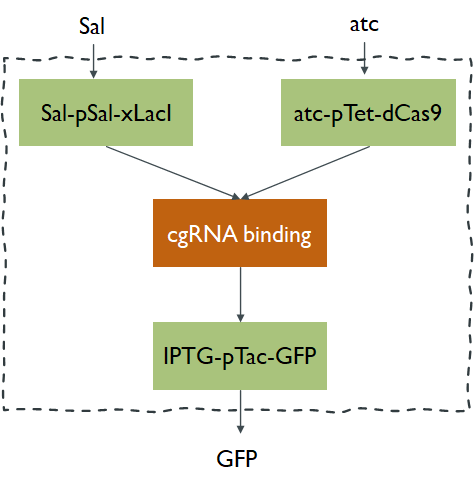

### Contracts for IPTG sensor

In [96]:
yleak_iptg = df.loc[df["Inducer"] == "IPTG"]["ymin (RPUx10-3)"].values[0]*1e-3
iptg_start = df.loc[df["Inducer"] == "IPTG"]["start"].values[0]
iptg_K = df.loc[df["Inducer"] == "IPTG"]["K (µM)"].values[0]
ymax_iptg = df.loc[df["Inducer"] == "IPTG"]["ymax Linear"].values[0]
iptg_output = "GFP"
contract_iptg_0, contract_iptg_lin, contract_iptg_max = create_sensor_contracts(input="IPTG", output=iptg_output, 
                                                                                start=iptg_start, K=iptg_K,
                                                                                ymax_lin=ymax_iptg, yleak=yleak_iptg)
# Recreate Sal contracts with "xLacI" output:
contract_sal_0, contract_sal_lin, contract_sal_max = create_sensor_contracts(input="Sal", output="xLacI", 
                                                                             start=sal_start, K=sal_K,
                                                                             ymax_lin=ymax_sal, yleak=yleak_sal)

Top-level contracts:

Full circuit

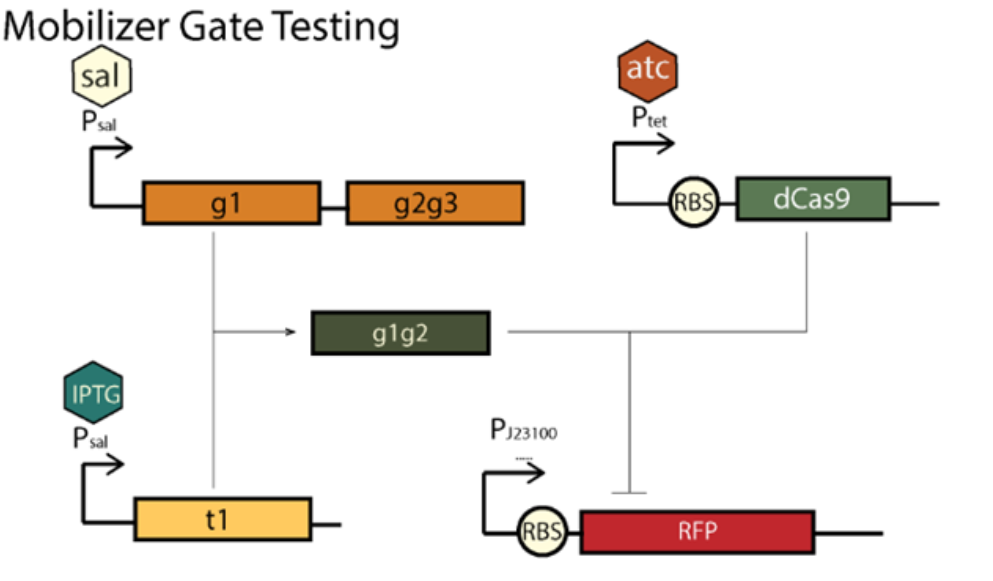

In [97]:
# Create all sensor contracts:
sensor_names = [str(i) for i in df['Inducer']]
sensor_library = {}
for sensor in sensor_names:
    yleak_s = df.loc[df["Inducer"] == sensor]["ymin (RPUx10-3)"].values[0]*1e-3
    s_start = df.loc[df["Inducer"] == sensor]["start"].values[0]
    s_K = df.loc[df["Inducer"] == sensor]["K (µM)"].values[0]
    ymax_s = df.loc[df["Inducer"] == sensor]["ymax Linear"].values[0]
    s_output = "dCas9"
    contract_s_0, contract_s_lin, contract_s_max = create_sensor_contracts(input=sensor, output="dCas9", 
                                                                           start=s_start, K=s_K,
                                                                           ymax_lin=ymax_s, yleak=yleak_s)
    sensor_library[sensor] = [contract_s_0, contract_s_lin, contract_s_max]

In [98]:
sensor_library['OHC14']

[{'_comment': 'contract when sensor is OFF',
  'InputVars': ['OHC14'],
  'OutputVars': ['dCas9'],
  'assumptions': [{'coefficients': {'OHC14': 1}, 'constant': 0.016}],
  'guarantees': [{'coefficients': {'dCas9': 1}, 'constant': 0.003}]},
 {'_comment': 'contract for sensor in linear regime',
  'InputVars': ['OHC14'],
  'OutputVars': ['dCas9'],
  'assumptions': [{'coefficients': {'OHC14': 1}, 'constant': 0.43},
   {'coefficients': {'OHC14': -1}, 'constant': -0.016}],
  'guarantees': [{'coefficients': {'dCas9': -1, 'OHC14': 1.683574879227053},
    'constant': -0.02393719806763285},
   {'coefficients': {'dCas9': 1, 'OHC14': -1.683574879227053},
    'constant': 0.02393719806763285}]},
 {'_comment': 'contract for sensor in saturation',
  'InputVars': ['OHC14'],
  'OutputVars': ['dCas9'],
  'assumptions': [{'coefficients': {'OHC14': -1}, 'constant': -0.43}],
  'guarantees': [{'coefficients': {'dCas9': -1}, 'constant': -0.7}]}]